In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bisect
import seaborn as sns
import LCDMSphere
import Energy_loss_class
import Source_class

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
k = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G

nstep = 199 # redshift grid
mstep = 199 # energy grid

In [2]:
# calculate overdensity evolution
C = LCDMSphere.XCosmo(0.6774, 0.319)
C.overdensity_evol(15., -10., nstep+1)
z_list = C.z_grid # redshift grid
delta_b = C.Delta_grid # overdensity of baryon
Delta_list = np.array([1 + x for x in delta_b]) # relative overdensity of baryon - grid
ln_Delta = [np.log(x) for x in Delta_list]

dDdz = np.zeros((nstep, )) # d ln(Delta)/dz
for i in range(nstep):
    dDdz[i] = (ln_Delta[i+1] - ln_Delta[i]) / (z_list[i+1] - z_list[i])

z = (z_list[:-1] + z_list[1:]) / 2 # midpoint of z grid, correspond to d ln(Delta)/dz
    
Delta = (Delta_list[:-1] + Delta_list[1:]) / 2 # midpoint of overdensity grid, correspond to d ln(Delta)/dz
    
H = np.zeros((nstep, ))
for i in range(nstep):
    H[i] = C.H(z[i])
    
theta = np.zeros((nstep, ))
for i in range(nstep):
    theta[i] = -3 / (1 + z[i]) + dDdz[i]

In [ ]:
# A1 = -theta, coefficient of N(E, z)

In [3]:
# coefficient of dN(E, z)/dE
def A2(E, z, Delta_i, theta_i, H):
    loss = Energy_loss_class.Loss(z, E, Delta_i)
    co1 = theta_i / 3 * E * (E + 2 * E_e) / (E + E_e)
    co2 = loss.E_loss() / (-(1 + z) * H)
    co = co1 - co2
    return co

In [4]:
# coefficient due to secondary electron
def A3(E, E_p, z, H): # E_p means E_prime
    omega_b = omega_b_0 * (1 + z)**3
    n_H = 0.76 * omega_b * rho_crit / m_p
    n_etot = n_H * (1 + 2 * f_He)
    beta_p = np.sqrt(E_p * (E_p + 2 * E_e)) / (E_p + E_e)
    co1 = 2 * np.pi * r0 * r0 * E_e * (E_e + E_p)**2 / E_p / (2 * E_e + E_p) / E / E
    co2 = 1 + E * E / (E_p - E)**2 + E * E / (E_e + E_p)**2 - E_e * (E_e + 2 * E_p) * E/ (E_e + E_p)**2 / (E_p - E)
    return n_etot * c * beta_p * co1 * co2 / (-(1 + z) * H)

In [5]:
E_min = 1e-8 # temp, in erg
E_max = 1e-3 # temp, in erg

E = np.logspace(np.log10(E_min), np.log10(E_max), mstep + 1)

E_mid = (E[:-1] + E[1:]) / 2 # midpoint for reference
E_plus = np.zeros((mstep+1, 1)) # E_{i+1/2} = sqrt(E[i] * E[i+1])
E_minus = np.zeros((mstep+1, 1)) # E_{i-1/2} = sqrt(E[i-1] * E[i])

for i in range(mstep):
    E_plus[i] = np.sqrt(E[i] * E[i+1]) # length len(E) -1

E_plus[-1] = E_plus[-2] * E[-1] / E[-2] # E[i+1]/E[i] is constant, so in E_plus and E_minus

for i in range(1, mstep+1):
    E_minus[i] = np.sqrt(E[i] * E[i-1])
    
E_minus[0] = E_minus[1] / (E[1]/E[0])

In [6]:
S = np.loadtxt("source_term.txt") # in 'same columns, same redshift; same row, same energy' format 
S = np.delete(S, 0, axis=1) 
Sz = [[S[i][j] / (-(1 + z[j]) * H[j]) for j in range(nstep)] for i in range(mstep)]

In [7]:
def get_M(z, Delta, theta, H): # parameters that only depend on redshift
    M = np.zeros((mstep, mstep))

    for i in range(mstep):
        for j in range(mstep):
            if j == i or j == i-1 or j == i+1:
                A1_ij = -theta
        
                A2_ij = A2(E[j], z, Delta, theta, H)
                A2_ij_p = A2(E_plus[j], z, Delta, theta, H)
                A2_ij_m = A2(E_minus[j], z, Delta, theta, H)
        
                dE = E[j+1] - E[j]
                dE_p = E_plus[j+1] - E_plus[j]
                dE_m = E_minus[j+1] - E_minus[j]
        
                if j == i: # subcribe of n is equal to j
                    M[i][j] += A1_ij + A2_ij_p/2/dE_p - A2_ij_m/2/dE_m - (A2_ij_p-A2_ij_m)/dE
                if j == i-1:
                    M[i][j] -= A2_ij_m / 2 / dE_m
                if j == i+1:
                    M[i][j] += A2_ij_p / 2 / dE_p
                
            if E[j] >= 2 * E[i]:
                M[i][j] += A3(E[i], E[j], z, H) # integrate E_p from 2E
                
    return M

In [8]:
SzdE = [[Sz[i][j]*(E_plus[i]-E_minus[i]) for j in range(nstep)] for i in range(mstep)]

In [9]:
def back_Euler(): # solve dn/dz = Mn + S using backward Euler method, M is square matrix, S is column vector
    n = np.zeros((mstep, 1))
    I = np.identity(mstep)
    
    for j in range(1, nstep): # initialize the first column to 0 with z[0], start from z[1]
        n_jm = np.zeros((mstep,1)) # partition column vector with redshift z[j-1]
        for i in range(mstep):
            n_jm[i] = n[i][j-1]
        
        dz = z[j] - z[j-1]
        
        S_j = np.zeros((mstep, 1))
        for i in range(mstep):
            S_j[i] = SzdE[i][j] # under same redshift, vari from different energy
        
        dzS = np.dot(dz, S_j)
        n_jm_plus_dzS = np.zeros((mstep, 1))
        for i in range(mstep):
            n_jm_plus_dzS[i] = n_jm[i] + dzS[i]
            
        M_j = get_M(z[j], Delta[j], theta[j], H[j]) # M matrix only depend on redshift
            
        dzM = np.dot(dz, M_j)
        I_minus_dzM = np.zeros((mstep,mstep))
        for i in range(mstep):
            for k in range(mstep):
                I_minus_dzM[i][k] = I[i][k]-dzM[i][k]
                
        I_m_inv = np.linalg.pinv(I_minus_dzM)
        
        n_j = np.dot(I_m_inv, n_jm_plus_dzS)
    
        n = np.hstack((n,n_j))
        
    return n

In [10]:
n = back_Euler()

In [11]:
N = np.zeros((mstep, nstep))
for i in range(mstep):
    for j in range(nstep):
        N[i][j] = n[i][j] / (E_plus[i] - E_minus[i])

<AxesSubplot:>

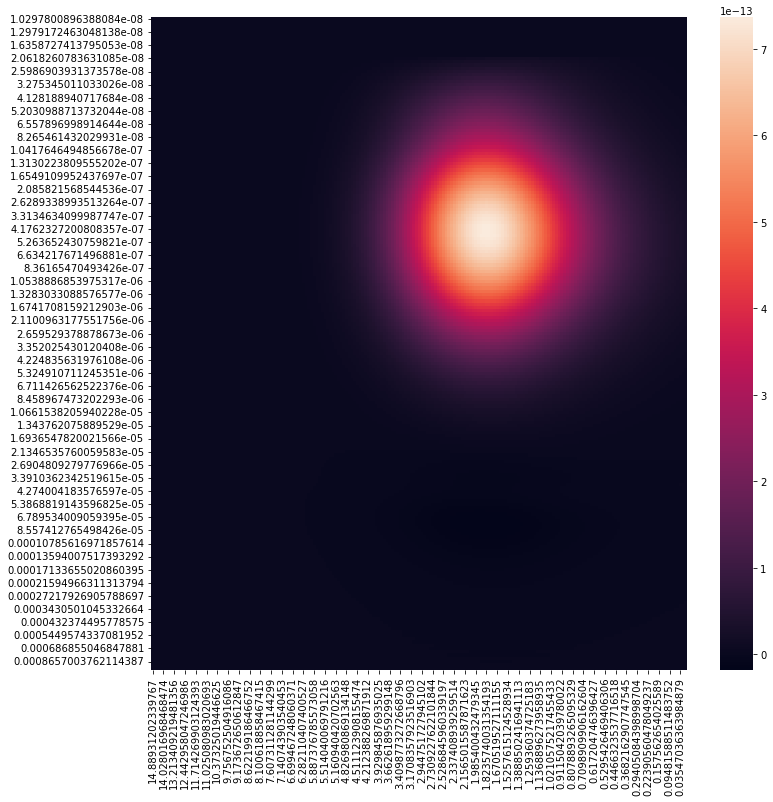

In [12]:
N_data = pd.DataFrame(data=N, index=E_mid, columns=z)
plt.figure(figsize = (12,12))
sns.heatmap(N_data)

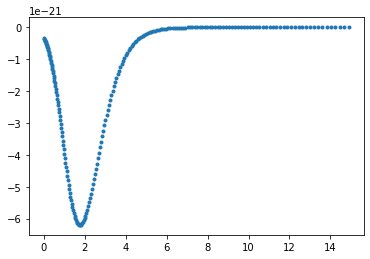

In [13]:
E_density = np.zeros((nstep, ))
for i in range(mstep):
    for j in range(nstep):
        E_density[j] += N[i][j] * E[i] * E[i]
plt.plot(z, E_density, '.')
plt.show()

In [17]:
count = 0
for i in range(mstep):
    for j in range(nstep):
        if N[i][j] < 0:
            count += 1
print(count)

15538
